## Transfer learning  Based on ResNet34 for Methylation Data

The network in this notebook is an implementation of the ResNet-50 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).

The ResNet-50 architecture is similar to the ResNet-34 architecture shown below (from [1]):


![](resnets/resnet34/resnet34-arch.png)

However, in ResNet-50, the skip connection uses a bottleneck (from [1]):


![](resnets/resnet50/resnet50-arch-1.png)



The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](resnets/resnet-ex-1-2.png)

The ResNet-50 uses a bottleneck as shown below:

![](resnets/resnet-ex-1-3.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import PosixPath
import time

In [3]:
import pandas as pd
import numpy as np

In [365]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary

## Settings

In [545]:
## Hyper-paremeters
BATCH_SIZE = 8
NUM_EPOCHS = 30
LEARNING_RATE = 0.00001
RANDOM_SEED = 42


## Model Architecture
NUM_CLASSES = 2

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Dataset explore

### GSE74845

[Dataset Link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74845)

The development of non-invasive primary cancer preventive measures in humans require a thorough understanding of the initial cancer-driving molecular mechanisms. High grade serous extra-uterine M llerian cancers (HGSEMC; formerly classified as ovarian/tubal/peritoneal cancer) present at a very late stage and less than 40% of women survive 5 years. Although the recent TCGA initiatives revealed key molecular changes in established cancers, very little is known about the initial molecular alterations in cancer development. Analysis of normal tissue at extensively high risk prior to the development of any microscopic alterations is critical. BRCA1/2 mutation carriers have an up to 30 40 fold increased risk to develop ovarian cancer, preferentially HGSEMC. Despite a plethora of evidence linking mutations in BRCA1 or BRCA2 to cancer development the core components such as organ specificity (i.e. to breast and Fallopian Tube) are still missing. The Fallopian Tube of BRCA mutation carriers offers a unique opportunity to study carcinogenesis because these cancers originate only from the distal (i.e. fimbrial) end of the Fallopian Tube (which is in close proximity to the ovary), and not from the proximal end (which is close to the uterus). The ovary which is in extreme close proximity to the fimbriae provides an excellent soil for cancer cells which are likely shed from the fimbriae and once the cancer has been discovered the big bulk of tumour is usually present on the ovary and hence the majority of HGSEMC are also referred to as ovarian cancer . To study the earliest steps of human carcinogenesis we performed epigenome-wide DNA methylation (DNAme) analyses (using the Illumina 450k DNA methylation bead-array assay assessing DNAme at ~480 000 CpG sites) in 215 microscopic normal Fallopian Tube samples of BRCA1/2 mutation carriers (n=56) and controls (n=59) who had their tubes/ovaries removed for prophylactic or other reasons, respectively (for 52 and 49 individuals respectively we analysed both fimbrial and proximal Fallopian Tubes). In order to adjust for any epigenetic effects which are not of immediate importance to the carcinogenic process, for each volunteer we analysed both the fimbrial (at risk) and the proximal (non at risk) portion of the tubes separately.

In [546]:
root_dir = PosixPath(".")
dataset_path = "GSE74845_series_matrix.txt"

In [369]:
data_matrix  = pd.read_table(root_dir/dataset_path)

In [370]:
data_matrix.head()

,ID_REF,GSM2132967,GSM2132968,GSM2132969,GSM2132970,GSM2132971,GSM2132972,GSM2132973,GSM2132974,GSM2132975,...,GSM2133183,GSM2133184,GSM2133185,GSM2133186,GSM2133187,GSM2133188,GSM2133189,GSM2133190,GSM2133191,GSM2133192
0,cg00000029,0.413567,0.341079,0.381044,0.418526,0.308511,0.415981,0.325744,0.611465,0.426866,...,0.486653,0.393736,0.565041,0.559429,0.503834,0.489559,0.488975,0.626374,0.684211,0.383244
1,cg00000108,0.943061,0.750692,0.913595,0.932710,0.914242,0.901047,0.916935,0.946930,0.935397,...,0.939712,0.914754,0.954812,0.960274,0.950043,0.944714,0.928777,0.944578,0.947195,0.947318
2,cg00000109,0.799719,0.917194,0.885665,0.889474,0.866218,0.927703,0.863381,0.864142,0.873000,...,0.957135,0.908891,0.951368,0.852136,0.892192,0.958426,0.938942,0.915518,0.870629,0.933809
3,cg00000165,0.212454,0.294118,0.420250,0.325410,0.282497,0.421712,0.341264,0.342029,0.280949,...,0.518261,0.464912,0.558984,0.418291,0.431217,0.413011,0.395184,0.598854,0.409190,0.471264
4,cg00000236,0.893922,0.911511,0.868725,0.805311,0.890320,0.916782,0.921667,0.872765,0.911796,...,0.865964,0.896430,0.894705,0.796170,0.914917,0.903630,0.848537,0.917473,0.840046,0.901202


In [371]:
data_matrix.shape

(470426, 217)

In [372]:
data_matrix.drop("ID_REF", inplace=True, axis = 1)

In [373]:
sample_names = "GSM2132967 GSM2132968 GSM2132969 GSM2132970 GSM2132971 GSM2132972 GSM2132973 GSM2132974 GSM2132975 GSM2132976 GSM2132977 GSM2132978 GSM2132979 GSM2132980 GSM2132981 GSM2132982 GSM2132983 GSM2132984 GSM2132985 GSM2132986 GSM2132987 GSM2132988 GSM2132989 GSM2132990 GSM2132991 GSM2132992 GSM2132993 GSM2132994 GSM2132995 GSM2132996 GSM2132997 GSM2132998 GSM2132999 GSM2133000 GSM2133001 GSM2133002 GSM2133003 GSM2133004 GSM2133005 GSM2133006 GSM2133007 GSM2133008 GSM2133009 GSM2133010 GSM2133011 GSM2133012 GSM2133013 GSM2133014 GSM2133015 GSM2133016 GSM2133017 GSM2133018 GSM2133019 GSM2133020 GSM2133021 GSM2133022 GSM2133023 GSM2133024 GSM2133025 GSM2133026 GSM2133027 GSM2133028 GSM2133029 GSM2133030 GSM2133031 GSM2133032 GSM2133033 GSM2133034 GSM2133035 GSM2133036 GSM2133037 GSM2133038 GSM2133039 GSM2133040 GSM2133041 GSM2133042 GSM2133043 GSM2133044 GSM2133045 GSM2133046 GSM2133047 GSM2133048 GSM2133049 GSM2133050 GSM2133051 GSM2133052 GSM2133053 GSM2133054 GSM2133055 GSM2133056 GSM2133057 GSM2133058 GSM2133059 GSM2133060 GSM2133061 GSM2133062 GSM2133063 GSM2133064 GSM2133065 GSM2133066 GSM2133067 GSM2133068 GSM2133069 GSM2133070 GSM2133071 GSM2133072 GSM2133073 GSM2133074 GSM2133076 GSM2133079 GSM2133081 GSM2133083 GSM2133085 GSM2133088 GSM2133090 GSM2133092 GSM2133093 GSM2133094 GSM2133095 GSM2133096 GSM2133097 GSM2133098 GSM2133099 GSM2133100 GSM2133101 GSM2133102 GSM2133103 GSM2133104 GSM2133105 GSM2133106 GSM2133107 GSM2133108 GSM2133109 GSM2133110 GSM2133111 GSM2133112 GSM2133113 GSM2133114 GSM2133115 GSM2133116 GSM2133117 GSM2133118 GSM2133119 GSM2133120 GSM2133121 GSM2133122 GSM2133123 GSM2133124 GSM2133125 GSM2133126 GSM2133127 GSM2133128 GSM2133129 GSM2133130 GSM2133131 GSM2133132 GSM2133133 GSM2133134 GSM2133135 GSM2133136 GSM2133137 GSM2133138 GSM2133139 GSM2133140 GSM2133141 GSM2133142 GSM2133143 GSM2133144 GSM2133145 GSM2133146 GSM2133147 GSM2133148 GSM2133149 GSM2133150 GSM2133151 GSM2133152 GSM2133153 GSM2133154 GSM2133155 GSM2133156 GSM2133157 GSM2133158 GSM2133159 GSM2133160 GSM2133161 GSM2133162 GSM2133163 GSM2133164 GSM2133165 GSM2133166 GSM2133167 GSM2133168 GSM2133169 GSM2133170 GSM2133171 GSM2133172 GSM2133173 GSM2133174 GSM2133175 GSM2133176 GSM2133177 GSM2133178 GSM2133179 GSM2133180 GSM2133181 GSM2133182 GSM2133183 GSM2133184 GSM2133185 GSM2133186 GSM2133187 GSM2133188 GSM2133189 GSM2133190 GSM2133191 GSM2133192"
sample_title = "Patient-23-fim    Patient-29-fim    Patient-28-fim    Patient-29-prox   Patient-24-fim    Patient-30-fim    Patient-24-prox   Patient-30-prox   Patient-27-prox   Patient-15-fim    Patient-27-fim    Patient-15-prox   Patient-17-fim    Patient-22-fim    Patient-18-prox   Patient-25-prox   Patient-18-fim    Patient-25-fim    Patient-31-prox   Patient-26-prox   Patient-31-fim    Patient-26-fim    Patient-22-prox   Patient-32-fim    Patient-32-prox   Patient-19-prox   Patient-14-prox   Patient-20-fim    Patient-14-fim    Patient-20-prox   Patient-16-prox   Patient-21-fim    Patient-16-fim    Patient-21-prox   Patient-19-fim    Patient-47-fim    Patient-47-prox   Patient-33-fim    Patient-42-prox   Patient-33-prox   Patient-46-fim    Patient-40-fim    Patient-46-prox   Patient-40-prox   Patient-48-fim    Patient-67-fim    Patient-48-prox   Patient-67-prox   Patient-69-fim    Patient-56-prox   Patient-69-prox   Patient-56-fim    Patient-70-fim    Patient-57-prox   Patient-70-prox   Patient-57-fim    Patient-50-prox   Patient-61-fim    Patient-54-fim    Patient-61-prox   Patient-63-fim    Patient-36-prox   Patient-63-prox   Patient-36-fim    Patient-49-prox   Patient-38-prox   Patient-49-fim    Patient-38-fim    Patient-34-fim    Patient-60-prox   Patient-34-prox   Patient-60-fim    Patient-35-prox   Patient-35-fim    Patient-37-fim    Patient-41-fim    Patient-37-prox   Patient-41-prox   Patient-39-prox   Patient-44-prox   Patient-39-fim    Patient-44-fim    Patient-43-prox   Patient-65-prox   Patient-43-fim    Patient-65-fim    Patient-45-prox   Patient-66-prox   Patient-45-fim    Patient-53-prox   Patient-64-prox   Patient-53-fim    Patient-64-fim    Patient-51-fim    Patient-51-prox   Patient-58-fim    Patient-52-fim    Patient-59-prox   Patient-52-prox   Patient-59-fim    Patient-55-prox   Patient-62-prox   Patient-55-fim    Patient-62-fim    Patient-58-prox   Patient-68-fim    Patient-68-prox   Patient-82-fim    Patient-93-prox   Patient-86-prox   Patient-93-fim    Patient-86-fim    Patient-103-prox  Patient-90-prox   Patient-103-fim   Patient-90-fim    Patient-73-prox   Patient-94-fim    Patient-95-prox   Patient-99-prox   Patient-95-fim    Patient-99-fim    Patient-96-prox   Patient-101-prox  Patient-96-fim    Patient-101-fim   Patient-97-prox   Patient-104-prox  Patient-97-fim    Patient-104-fim   Patient-71-prox   Patient-76-prox   Patient-71-fim    Patient-76-fim    Patient-74-fim    Patient-77-prox   Patient-74-prox   Patient-77-fim    Patient-75-prox   Patient-109-fim   Patient-75-fim    Patient-109-prox  Patient-111-prox  Patient-92-fim    Patient-111-fim   Patient-92-prox   Patient-105-fim   Patient-84-fim    Patient-105-prox  Patient-84-prox   Patient-115-fim   Patient-87-fim    Patient-115-prox  Patient-87-prox   Patient-98-fim    Patient-72-fim    Patient-98-prox   Patient-72-prox   Patient-100-fim   Patient-78-fim    Patient-100-prox  Patient-102-fim   Patient-79-fim    Patient-102-prox  Patient-80-fim    Patient-80-prox   Patient-85-prox   Patient-81-fim    Patient-88-fim    Patient-81-prox   Patient-88-prox   Patient-83-fim    Patient-89-fim    Patient-83-prox   Patient-89-prox   Patient-85-fim    Patient-91-fim    Patient-91-prox   Patient-108-prox  Patient-114-fim   Patient-108-fim   Patient-114-prox  Patient-110-prox  Patient-106-fim   Patient-110-fim   Patient-106-prox  Patient-112-fim   Patient-107-prox  Patient-112-prox  Patient-113-fim   Patient-5-prox    Patient-113-prox  Patient-5-fim Patient-1-prox    Patient-12-fim    Patient-1-fim Patient-12-prox   Patient-4-prox    Patient-13-prox   Patient-4-fim Patient-13-fim    Patient-2-fim Patient-7-prox    Patient-2-prox    Patient-8-fim Patient-3-prox    Patient-8-prox    Patient-3-fim Patient-9-prox    Patient-6-fim Patient-9-fim Patient-7-fim Patient-10-fim    Patient-10-prox   Patient-11-fim    Patient-11-prox"

In [374]:
target_dict = {sample: label for sample, label in zip(sample_names.split(), sample_title.split())}

In [375]:
target_dict

{'GSM2132967': 'Patient-23-fim',
 'GSM2132968': 'Patient-29-fim',
 'GSM2132969': 'Patient-28-fim',
 'GSM2132970': 'Patient-29-prox',
 'GSM2132971': 'Patient-24-fim',
 'GSM2132972': 'Patient-30-fim',
 'GSM2132973': 'Patient-24-prox',
 'GSM2132974': 'Patient-30-prox',
 'GSM2132975': 'Patient-27-prox',
 'GSM2132976': 'Patient-15-fim',
 'GSM2132977': 'Patient-27-fim',
 'GSM2132978': 'Patient-15-prox',
 'GSM2132979': 'Patient-17-fim',
 'GSM2132980': 'Patient-22-fim',
 'GSM2132981': 'Patient-18-prox',
 'GSM2132982': 'Patient-25-prox',
 'GSM2132983': 'Patient-18-fim',
 'GSM2132984': 'Patient-25-fim',
 'GSM2132985': 'Patient-31-prox',
 'GSM2132986': 'Patient-26-prox',
 'GSM2132987': 'Patient-31-fim',
 'GSM2132988': 'Patient-26-fim',
 'GSM2132989': 'Patient-22-prox',
 'GSM2132990': 'Patient-32-fim',
 'GSM2132991': 'Patient-32-prox',
 'GSM2132992': 'Patient-19-prox',
 'GSM2132993': 'Patient-14-prox',
 'GSM2132994': 'Patient-20-fim',
 'GSM2132995': 'Patient-14-fim',
 'GSM2132996': 'Patient-20-pro

In [376]:
data_matrix.dropna(axis = 0,inplace=True)

In [377]:
data_matrix.shape

(470425, 216)

In [378]:
torch.from_numpy(data_matrix.iloc[:,1].values).size()

torch.Size([470425])

In [379]:
def transform_target(target):
    if target.split("-")[-1] == "prox":
        return 0
    else:
        return 1   

In [380]:
target_dict = {target : transform_target(target_dict[target]) for target in target_dict}

In [381]:
data_matrix.iloc[:,0].values

array([0.41356674, 0.94306078, 0.79971923, ..., 0.42618182, 0.65923307,
       0.92669805])

In [382]:
len(target_dict),sum(target_dict.values())

(216, 110)

In [547]:
class GSEDataset(Dataset):
    def __init__(self, data_matrix, target_dict):
        self.data_matrix = data_matrix
        self.target_dict = target_dict
    
    def __len__(self):
        return len(self.target_dict)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data_matrix.iloc[:,idx].values).float()
        y = torch.tensor(self.target_dict[self.data_matrix.columns[idx]])
        return x,y

In [548]:
ges_dataset =  GSEDataset(data_matrix, target_dict)

In [549]:
train_size = int(0.8 * len(ges_dataset))
test_size = len(ges_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(ges_dataset, [train_size, test_size])

In [550]:
train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

dataset_loader = {"train": train_dataloader, "test": test_dataloader}

## Transfer Model

In [551]:
resnet = torchvision.models.resnet18(pretrained=True)

In [552]:
for index, (name, layer) in enumerate(resnet.named_children()):
    print(index, name, " -> ", layer)
    print("--"* 40)

0 conv1  ->  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------------------------------------------------------------------
1 bn1  ->  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
--------------------------------------------------------------------------------
2 relu  ->  ReLU(inplace=True)
--------------------------------------------------------------------------------
3 maxpool  ->  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
--------------------------------------------------------------------------------
4 layer1  ->  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64

In [553]:
x,y = next(iter(dataset_loader["train"]))

In [554]:
x.size(), y.size()

(torch.Size([8, 470425]), torch.Size([8]))

In [555]:
def div_prime(num):
    res = []
    while num != 1:
        for i in range(2, int(num+1)):
            if num % i == 0:
                res.append(i)
                num = num // i
                break
 
    return res
div_prime(470425)

[5, 5, 31, 607]

# Model

In [556]:
class GESMODEL(torch.nn.Module):
    def __init__(self, num_class = NUM_CLASSES):
        super(GESMODEL, self).__init__()
        
        
        self.pre = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=5, out_channels=3, kernel_size= 1, stride=1, padding=0, bias = False),
            torch.nn.ReLU(inplace = True),
            torch.nn.BatchNorm2d(3),
            torch.nn.AdaptiveAvgPool2d((224,224)),
            
        )
        

        self.base_model = models.resnet34(pretrained=True)
#         for param in self.base_model.parameters():
#             param.requires_grad = False
            
        self.base_layers = list(self.base_model.children())
        
            
        
        self.middle = nn.Sequential(*self.base_layers[:6])
        
        self.last = nn.Sequential(
            torch.nn.Conv2d(in_channels = 128, out_channels = 2, kernel_size = 1, stride = 1, padding = 0, bias = False),
            torch.nn.BatchNorm2d(2),
            torch.nn.AdaptiveAvgPool2d(1),
        )
        
        
        for layer in self.pre.modules():
            if isinstance(layer, torch.nn.Conv2d):
                n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
                layer.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(layer, torch.nn.BatchNorm2d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()
                
        for layer in self.last.modules():
            if isinstance(layer, torch.nn.Conv2d):
                n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
                layer.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(layer, torch.nn.BatchNorm2d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()
                
        
    def forward(self, x):
        x = x.view(-1, 5,155,607)
        x = self.pre(x)
        x = self.middle(x)
#         print(x.size()) # torch.Size([2, 512, 7, 7])
        x = self.last(x)
        logits = torch.squeeze(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas

In [557]:
model = GESMODEL().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [558]:
summary(model, (470425,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 155, 607]              15
              ReLU-2          [-1, 3, 155, 607]               0
       BatchNorm2d-3          [-1, 3, 155, 607]               6
 AdaptiveAvgPool2d-4          [-1, 3, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

## Training

In [559]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [560]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())

            print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, loss))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["test"], device)
            
            print('Epoch: {0:03d}/{1:03d} train acc: {2:.3f} % | val acc: {3:.3f} % | time: {4:.3f} s'.format(
                  epoch+1, num_epochs, train_acc, valid_acc, end-start))
            

            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return model, loss_list, train_acc_list, valid_acc_list

In [561]:
model, loss_list, train_acc_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/030 | Batch 000/021 | Loss: 0.70
Epoch: 001/030 | Batch 001/021 | Loss: 0.69
Epoch: 001/030 | Batch 002/021 | Loss: 0.70
Epoch: 001/030 | Batch 003/021 | Loss: 0.71
Epoch: 001/030 | Batch 004/021 | Loss: 0.69
Epoch: 001/030 | Batch 005/021 | Loss: 0.69
Epoch: 001/030 | Batch 006/021 | Loss: 0.68
Epoch: 001/030 | Batch 007/021 | Loss: 0.70
Epoch: 001/030 | Batch 008/021 | Loss: 0.70
Epoch: 001/030 | Batch 009/021 | Loss: 0.69
Epoch: 001/030 | Batch 010/021 | Loss: 0.69
Epoch: 001/030 | Batch 011/021 | Loss: 0.70
Epoch: 001/030 | Batch 012/021 | Loss: 0.69
Epoch: 001/030 | Batch 013/021 | Loss: 0.70
Epoch: 001/030 | Batch 014/021 | Loss: 0.70
Epoch: 001/030 | Batch 015/021 | Loss: 0.73
Epoch: 001/030 | Batch 016/021 | Loss: 0.69
Epoch: 001/030 | Batch 017/021 | Loss: 0.70
Epoch: 001/030 | Batch 018/021 | Loss: 0.69
Epoch: 001/030 | Batch 019/021 | Loss: 0.69
Epoch: 001/030 | Batch 020/021 | Loss: 0.69
Epoch: 001/030 | Batch 021/021 | Loss: 0.68
Epoch: 001/030 train acc: 50.581

Epoch: 008/030 train acc: 84.302 % | val acc: 81.818 % | time: 2.482 s
Epoch: 009/030 | Batch 000/021 | Loss: 0.66
Epoch: 009/030 | Batch 001/021 | Loss: 0.66
Epoch: 009/030 | Batch 002/021 | Loss: 0.61
Epoch: 009/030 | Batch 003/021 | Loss: 0.64
Epoch: 009/030 | Batch 004/021 | Loss: 0.67
Epoch: 009/030 | Batch 005/021 | Loss: 0.65
Epoch: 009/030 | Batch 006/021 | Loss: 0.63
Epoch: 009/030 | Batch 007/021 | Loss: 0.63
Epoch: 009/030 | Batch 008/021 | Loss: 0.63
Epoch: 009/030 | Batch 009/021 | Loss: 0.67
Epoch: 009/030 | Batch 010/021 | Loss: 0.68
Epoch: 009/030 | Batch 011/021 | Loss: 0.63
Epoch: 009/030 | Batch 012/021 | Loss: 0.64
Epoch: 009/030 | Batch 013/021 | Loss: 0.62
Epoch: 009/030 | Batch 014/021 | Loss: 0.67
Epoch: 009/030 | Batch 015/021 | Loss: 0.61
Epoch: 009/030 | Batch 016/021 | Loss: 0.63
Epoch: 009/030 | Batch 017/021 | Loss: 0.68
Epoch: 009/030 | Batch 018/021 | Loss: 0.70
Epoch: 009/030 | Batch 019/021 | Loss: 0.69
Epoch: 009/030 | Batch 020/021 | Loss: 0.64
Epoch

Epoch: 016/030 | Batch 020/021 | Loss: 0.52
Epoch: 016/030 | Batch 021/021 | Loss: 0.50
Epoch: 016/030 train acc: 92.442 % | val acc: 77.273 % | time: 2.477 s
Epoch: 017/030 | Batch 000/021 | Loss: 0.58
Epoch: 017/030 | Batch 001/021 | Loss: 0.47
Epoch: 017/030 | Batch 002/021 | Loss: 0.56
Epoch: 017/030 | Batch 003/021 | Loss: 0.52
Epoch: 017/030 | Batch 004/021 | Loss: 0.54
Epoch: 017/030 | Batch 005/021 | Loss: 0.61
Epoch: 017/030 | Batch 006/021 | Loss: 0.54
Epoch: 017/030 | Batch 007/021 | Loss: 0.46
Epoch: 017/030 | Batch 008/021 | Loss: 0.47
Epoch: 017/030 | Batch 009/021 | Loss: 0.59
Epoch: 017/030 | Batch 010/021 | Loss: 0.51
Epoch: 017/030 | Batch 011/021 | Loss: 0.51
Epoch: 017/030 | Batch 012/021 | Loss: 0.45
Epoch: 017/030 | Batch 013/021 | Loss: 0.60
Epoch: 017/030 | Batch 014/021 | Loss: 0.46
Epoch: 017/030 | Batch 015/021 | Loss: 0.47
Epoch: 017/030 | Batch 016/021 | Loss: 0.47
Epoch: 017/030 | Batch 017/021 | Loss: 0.60
Epoch: 017/030 | Batch 018/021 | Loss: 0.51
Epoch

Epoch: 024/030 | Batch 018/021 | Loss: 0.40
Epoch: 024/030 | Batch 019/021 | Loss: 0.62
Epoch: 024/030 | Batch 020/021 | Loss: 0.35
Epoch: 024/030 | Batch 021/021 | Loss: 0.70
Epoch: 024/030 train acc: 97.093 % | val acc: 86.364 % | time: 2.493 s
Epoch: 025/030 | Batch 000/021 | Loss: 0.47
Epoch: 025/030 | Batch 001/021 | Loss: 0.46
Epoch: 025/030 | Batch 002/021 | Loss: 0.40
Epoch: 025/030 | Batch 003/021 | Loss: 0.34
Epoch: 025/030 | Batch 004/021 | Loss: 0.36
Epoch: 025/030 | Batch 005/021 | Loss: 0.39
Epoch: 025/030 | Batch 006/021 | Loss: 0.48
Epoch: 025/030 | Batch 007/021 | Loss: 0.34
Epoch: 025/030 | Batch 008/021 | Loss: 0.49
Epoch: 025/030 | Batch 009/021 | Loss: 0.36
Epoch: 025/030 | Batch 010/021 | Loss: 0.33
Epoch: 025/030 | Batch 011/021 | Loss: 0.37
Epoch: 025/030 | Batch 012/021 | Loss: 0.43
Epoch: 025/030 | Batch 013/021 | Loss: 0.40
Epoch: 025/030 | Batch 014/021 | Loss: 0.32
Epoch: 025/030 | Batch 015/021 | Loss: 0.47
Epoch: 025/030 | Batch 016/021 | Loss: 0.38
Epoch

## Result

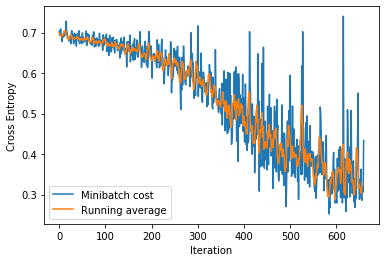

In [562]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(5,)/5, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

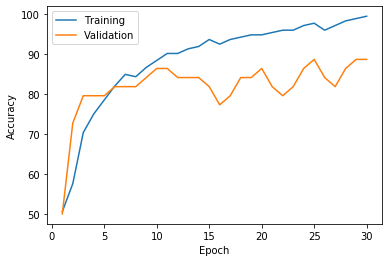

In [563]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [564]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=dataset_loader["test"],
                           device=DEVICE)

print(f'Test ACC: {test_acc:.2f}%')

Test ACC: 88.64%
